# Project 4 - Team T.W. Schultz
In this project, we will be exploring food demand and nutrition in Uganda.

### Preface




There are a few modules you may need to install:



In [1]:
!pip install CFEDemands --upgrade
!pip install xarray
!pip install dvc[gdrive]
!pip install h5netcdf

Requirement already up-to-date: CFEDemands in /opt/conda/lib/python3.8/site-packages (0.2.9)


### Import Statements

In [2]:
import cfe
import numpy as np
from eep153_tools import read_sheets
import matplotlib.pyplot as plt
import pandas as pd

### Getting Our Data

We will be using the provided data on Uganda:

In [3]:
COUNTRY = 'Uganda'

In [4]:
URL = {'Uganda':'https://docs.google.com/spreadsheets/d/1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ/',
       'Tanzania':'https://docs.google.com/spreadsheets/d/1Tknc2F8K6SaA7j0R7J_NE8yJBTsCPPw77_Bfc04MY40/',
       'ICRISAT':'https://docs.google.com/spreadsheets/d/13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo'}
DAYS_PER_PERIOD = {'Uganda':7,'Tanzania':7,'ICRISAT':365.25} # Number of days of expenditure recall

To read the various sheets, we&rsquo;ll need some credentials.  Import a
 function to read google sheets, and point to an
 unencrypted json file that has the appropriate permissions:



In [5]:
my_creds = '../students.json'

### Demand System Estimation



First, we pull in data and estimate CFE demands *given* the prices
    and budgets of households in the data.



In [6]:
x = read_sheets(URL[COUNTRY],json_creds=my_creds,sheet='Expenditures').set_index(['j','t','m'])
x.columns.name = 'i'
x = x.replace(0,np.nan)
y = np.log(x)

z = read_sheets(URL[COUNTRY],json_creds=my_creds,sheet='HH Characteristics').set_index(['j','t','m'])
z.columns.name = 'k'

p = read_sheets(URL[COUNTRY],json_creds=my_creds,sheet='Prices').set_index(['t','m'])
p.columns.name = 'i'

r = cfe.Result(y=y,z=z,prices=p)

r.get_alpha()
xhat = r.get_predicted_expenditures()

/opt/conda/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Estimation is kind of expensive, so you might want to save these
 results to use in your later code.



In [7]:
r.to_dataset("%s Data.ds" % COUNTRY)

/opt/conda/lib/python3.8/site-packages/h5netcdf/core.py:769: FutureWarning: String decoding changed with h5py >= 3.0. See https://docs.h5py.org/en/latest/strings.html for more details. Currently backwards compatibility with h5py < 3.0 is kept by decoding vlen strings per default. This will change in future versions for consistency with h5py >= 3.0. To silence this warning set kwarg ``decode_vlen_strings=False``. Setting ``decode_vlen_strings=True`` forces vlen string decoding.
  warnings.warn(msg, FutureWarning, stacklevel=0)


<xarray.Dataset>
Dimensions:           (i: 51, j: 10159, k: 15, kp: 15, m: 1, t: 6)
Coordinates:
  * j                 (j) object '1013000201' '1013000202' ... 'H4301001'
  * i                 (i) object 'Beans' 'Beef' ... 'Water' 'Wheat (flour)'
  * k                 (k) object 'F 00-03' 'M 00-03' ... 'M 51+' 'log HSize'
  * t                 (t) object '2005-06' '2009-10' ... '2013-14' '2015-16'
  * m                 (m) object 'Uganda'
  * kp                (kp) <U9 'F 00-03' 'F 04-08' ... 'M 51+' 'log HSize'
Data variables:
    alpha             (i) float64 6.538 7.501 8.361 6.426 ... 5.816 nan nan
    beta              (i) float64 0.2344 0.3721 0.5759 0.6146 ... 0.462 nan nan
    delta             (k, i) float64 -0.018 -0.02526 -0.01543 ... nan nan
    prices            (i, t, m) float64 600.0 1.25e+03 ... 2.5e+03 2.7e+03
    characteristics   (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... nan nan nan 1.946
    loglambdas        (j, t, m) float64 -1.233 0.01116 -0.6326 ... nan -0.4518
    a                 (i, t, m) float64 6.538 7.082 7.292 7.389 ... nan nan nan
    yhat              (j, t, m, i) float64 6.88 8.041 9.117 ... 7.259 nan nan
    ce                (j, t, m, i) float64 nan 1.118 -0.6234 ... -0.8352 nan nan
    cehat             (j, t, m, i) float64 0.2891 0.4588 0.7102 ... nan nan
    e                 (i, j, m, t) float64 nan nan nan nan ... nan nan nan nan
    delta_covariance  (i, k, kp) float64 0.0001698 2.553e-05 ... nan nan
    beta_covariance   object None
    se_delta          (i, k) float64 0.01303 0.01329 0.01108 ... nan nan nan
    se_beta           object None
    se_alpha          (i) float64 0.01585 0.01851 0.07667 ... 0.01593 0.0 0.0
    se_a              (i, t, m) float64 0.01585 0.01713 0.0173 ... nan nan nan
    y                 (i, j, m, t) float64 nan nan nan nan ... nan nan nan nan
    logp              (i, t, m) float64 6.397 7.131 7.313 ... nan 7.824 7.901
    z                 (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... nan nan nan 1.946

By the same token, if you&rsquo;ve **already** saved the estimated result, you
 can skip estimation and just  load it&#x2026;



In [8]:
import cfe
r = cfe.from_dataset("%s Data.ds" % COUNTRY)

Let's look at the demand elasticities and overall consumption of foods in Uganda.

In [9]:
beta = r.get_beta(as_df=True)
beta

i
Beans              0.234401
Beef               0.372068
Beer               0.575916
Bun                0.614612
Butter, etc.            NaN
Cabbages           0.302597
Cassava            0.100006
Cassava (flour)         NaN
Chicken            0.324125
Cigarettes         0.533225
Coffee             0.655771
Cooking oil        0.454043
Dodo               0.337421
Dried fish         0.337026
Eggs               0.454384
Fresh fish         0.387190
Fresh milk         0.570633
Ghee                    NaN
Goat meat          0.377250
Ground nut         0.310636
Infant formula          NaN
Irish potato       0.320683
Maize              0.248386
Mangos             0.396619
Matoke             0.438673
Millet             0.195983
Onions             0.423031
Oranges            0.560503
Other Alcohol      0.424832
Other Fruit        0.575993
Other Tobacco      0.497631
Other Veg.         0.439217
Other drinks            NaN
Other foods        0.709945
Other meat              NaN
Passion fruit     

In [10]:
alpha = r.get_alpha(as_df = True)
alpha

i
Beans             6.537682
Beef              7.500638
Beer              8.360626
Bun               6.425699
Cabbages          5.882989
Cassava           6.592677
Chicken           8.063880
Cigarettes        6.813737
Coffee            4.628108
Cooking oil       5.962613
Dodo              5.574761
Dried fish        6.520910
Eggs              6.182399
Fresh fish        7.015686
Fresh milk        6.832323
Goat meat         7.277119
Ground nut        6.229871
Irish potato      6.807111
Maize             6.619745
Mangos            6.009520
Matoke            7.386895
Millet            6.335612
Onions            4.994139
Oranges           5.658361
Other Alcohol     6.883310
Other Fruit       6.053041
Other Tobacco     5.445785
Other Veg.        5.579663
Other foods       6.864447
Passion fruit     6.241966
Peas              6.197789
Pork              7.083545
Restaurant        8.074264
Rice              6.708283
Salt              4.233558
Sim sim           6.166700
Soda              7.077052

### Ceteris Paribus



We begin by setting up some benchmarks for prices and budgets, so
    the things we don&rsquo;t want to change we can hold fixed.



In [11]:
### First year, first market, and some good.  Change if you wish! ###
my_t = r.coords['t'].data.flatten()[0]
my_m = r.coords['m'].data.flatten()[0]
my_i = r.coords['i'].data.flatten()[0]
#####################################################################

p = r.prices.sel(t=my_t,m=my_m,drop=True)
phat = p.to_dataframe('i').dropna().squeeze()

ref_price = r.prices.sel(i=my_i,t=my_t,m=my_m)
P = np.linspace(ref_price/10,ref_price*5,50)

def my_prices(p0,p=phat,i=my_i):
    """
    Set price of good i to p0, holding remaining prices fixed at values in p.
    """
    p = p.copy()
    p.loc[i] = p0
    return p.squeeze()

Here are the average prices for most foods in the data:

In [12]:
phat

i
Beans                600.000000
Beef                2500.000000
Beer                2800.000000
Bun                 1200.000000
Butter, etc.        3200.000000
Cassava              150.000000
Cassava (flour)      333.333333
Chicken             3000.000000
Cigarettes          8000.000000
Coffee               800.000000
Cooking oil          454.545455
Dodo                 100.000000
Dried fish           700.000000
Fresh fish          1000.000000
Fresh milk           400.000000
Ghee                4000.000000
Goat meat           2500.000000
Ground nut          1200.000000
Infant formula      8000.000000
Irish potato         250.000000
Maize                600.000000
Mangos                66.666667
Matoke               250.000000
Millet               500.000000
Onions               800.000000
Oranges              250.000000
Other Alcohol        800.000000
Other Fruit          225.000000
Other Tobacco      20000.000000
Other Veg.           200.000000
Other drinks         333.333333
Other 

### Nutrient Demands



The nutrient value of food consumed by the household is just the
   product of its diet and a food conversion table.  So let&rsquo;s write a
   function that describes that product:



In [13]:
# Get FCT:
fct = read_sheets(URL[COUNTRY],
                  json_creds='../students.json',
                  sheet='FCT').set_index('i')
fct.columns.name='n'

def nutrient_demand(x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

In [14]:
fct

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,,,,,,,,,,,,,,,
Beans,1060,65,50,1040,270,191,16.0,2.86,0.49,0.87,0,0.0,0.73,14,7.0
Beef,2910,264,0,50,90,0,27.0,33.50,2.20,0.50,0,18.5,1.70,0,60.0
Beer,430,5,0,60,40,35,0.0,5.10,0.30,0.10,0,0.2,0.50,0,0.0
Bread,2660,76,20,1110,1510,506,37.0,43.85,3.31,4.55,0,0.0,0.84,0,7.0
Bun,2660,76,20,1110,1510,506,37.0,43.85,3.31,4.55,0,0.0,0.84,0,7.0
Cabbages,250,13,30,430,400,58,5.0,2.34,0.40,0.61,50,0.0,1.24,366,2.0
Cassava,1600,14,20,270,160,381,3.0,8.54,0.48,0.87,10,0.0,0.88,206,3.0
Cassava (flour),3140,26,40,360,310,766,19.0,14.00,0.50,3.10,70,0.0,7.00,720,7.0
Chapati,2750,91,20,240,860,557,14.0,21.42,0.97,2.67,0,0.0,0.34,0,8.0


### Nutritional requirements



Individuals have nutritional requirements established by nutrition
 scientists.  Here we grab one such set of requirements:



In [15]:
rdi = read_sheets(URL[COUNTRY],
                  json_creds='../students.json',
                  sheet='RDI').set_index('n').replace(np.nan,0)
rdi.columns.name = 'k'

rdi = rdi.replace('',0)
rdi

k,M 00-03,F 04-08,M 04-08,F 09-13,M 09-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
n,,,,,,,,,,,,,
Energy,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
Fiber,14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
Folate,150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
Calcium,700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0
Carbohydrate,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0
Iron,7.0,10.0,10.0,8.0,8.0,15.0,11.0,18.0,8.0,18.0,8.0,8.0,8.0
Magnesium,80.0,130.0,130.0,240.0,240.0,360.0,410.0,310.0,400.0,320.0,420.0,320.0,420.0
Niacin,6.0,8.0,8.0,12.0,12.0,14.0,16.0,14.0,16.0,14.0,16.0,14.0,16.0


#### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
    can&rsquo;t directly compare household level nutrition with individual
    level requirements.  What we **can** do is add up minimum individual
    requirements, and see whether household total exceed these.  This
    isn&rsquo;t a guarantee that all individuals have adequate nutrition
    (since the way food is allocated in the household might be quite
    unequal, or unrelated to individual requirements), but it is
    *necessary* if all individuals are to have adequate nutrition.

For the average household, the number of different kinds of people
can be computed by averaging over households:



In [16]:
# Find average household characteristics for reference period & place
zbar = r.z.sel(t=my_t,m=my_m,drop=True).mean('j').to_dataframe()

Now, the inner/dot/matrix product between `zbar` and the `rda`
 DataFrame of requirements will give us minimum requirements for the
 average household:



In [17]:
# This matrix product gives minimum nutrient requirements for average
# household in reference year & place
my_rdi,my_zbar = rdi.align(zbar.T,axis=1,join='inner')
hh_rdi = my_rdi@my_zbar.T

# But this is per *day*, while our data is per period:
hh_rdi = hh_rdi*DAYS_PER_PERIOD[COUNTRY]
hh_rdi

,z
n,
Energy,61649.775785
Protein,1366.551570
Fiber,863.096861
Folate,11449.775785
Calcium,37338.565022
Carbohydrate,4511.233184
Iron,379.840807
Magnesium,9815.201794
Niacin,436.834081


#### Nutritional Adequacy of Food Demands



Since we can trace out demands for nutrients as a function of $(x,p)$,
 and we&rsquo;ve computed minimum nutritional requirements for the average
 household, we can *normalize* nutritional intake to check the adequacy
 of diet.



In [18]:
def nutrient_adequacy_ratio(x,p):
    return (nutrient_demand(x,p)/hh_rdi.T).squeeze()

#### Where do we start?

We would like to see which nutrients lower-income households are lacking, so for now, we are going to use all the nutrients.

In [19]:
UseNutrients = fct.columns.tolist()

### Income Levels
We will be choosing the quantiles of income we're interested in. We will start by seeing the median household income level in Uganda and if the recommended intake of nutrients are met.

In [20]:
# A quantile of 0.5 is the median.  Play with quantile value, or just assign.
xbar = r.get_predicted_expenditures().sel(t=my_t,m=my_m).sum('i')

# Drop households with /no/ predicted expenditures
xbar = xbar.where(xbar>0)

x0 = xbar.quantile(0.5,'j') # Budget (median household)
#x0 = 50

median_x = x0

# Range of budgets to explore
X = np.linspace(x0/10,x0*5,50)

/opt/conda/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


The graph below would show us the nutrient adequacy in relation to budget, which can represent household income. The closer the lines are to the horizontal line at 0, or perhaps above it, the better. So the nutrients we want to study are ones that are noticeably below that horizontal line at lower income levels.

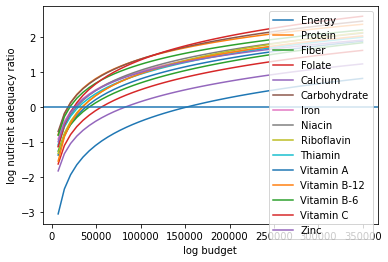

In [21]:
plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('log budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)

The three graphs below show the nutritional adequacy of the bottom 25%, median, and top 25% of households in regards to budget (income) in Uganda, respectively. The vertical line at 0 represents the baseline adequacy; therefore, it is better to have more lines to the right of this vertical line. If there are lines to the left, then it means that those households are not meeting the recommendeded daily intake for those nutrients.

Text(0.5, 1.0, 'Nutritional Adequacy of the Bottom 25% Income Household in Uganda')

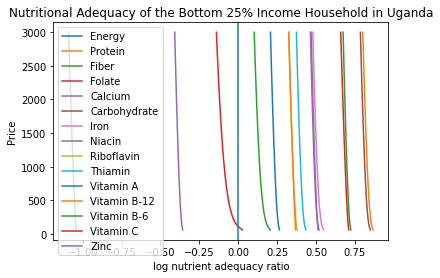

In [22]:
poorer_x = xbar.quantile(0.25, 'j')

plt.plot(pd.concat({p0:np.log(nutrient_adequacy_ratio(poorer_x,my_prices(p0,i=my_i)))[UseNutrients] for p0 in P},axis=1).T,P)
plt.legend(UseNutrients)
plt.ylabel('Price')
plt.xlabel('log nutrient adequacy ratio')
plt.axvline(0)
plt.title('Nutritional Adequacy of the Bottom 25% Income Household in Uganda')

Text(0.5, 1.0, 'Nutritional Adequacy of the Median Income Household in Uganda')

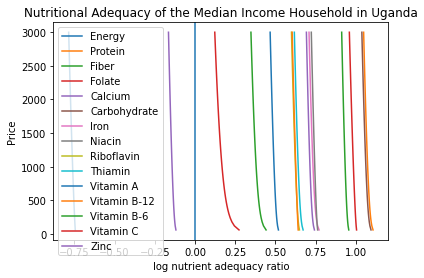

In [23]:
median_x = x0

plt.plot(pd.concat({p0:np.log(nutrient_adequacy_ratio(median_x,my_prices(p0,i=my_i)))[UseNutrients] for p0 in P},axis=1).T,P)
plt.legend(UseNutrients)
plt.ylabel('Price')
plt.xlabel('log nutrient adequacy ratio')
plt.axvline(0)
plt.title('Nutritional Adequacy of the Median Income Household in Uganda')

Text(0.5, 1.0, 'Nutritional Adequacy of the Top 25% Income Household in Uganda')

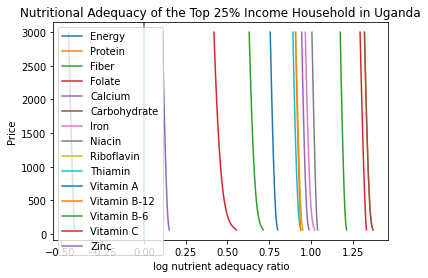

In [24]:
wealthier_x = xbar.quantile(0.75, 'j')

plt.plot(pd.concat({p0:np.log(nutrient_adequacy_ratio(wealthier_x,my_prices(p0,i=my_i)))[UseNutrients] for p0 in P},axis=1).T,P)
plt.legend(UseNutrients)
plt.ylabel('Price')
plt.xlabel('log nutrient adequacy ratio')
plt.axvline(0)
plt.title('Nutritional Adequacy of the Top 25% Income Household in Uganda')

For those three graphs, it is a little difficult to see the line on the very left of the graphs, but that line represents vitamin A.

As shown, lower income households tend to be below their daily recommended intake for calcium and vitamin A. So we would like to look at those two nutrients when designing policy.

We are now going to redefine our UseNutrients variable to just calcium and vitamin A.

In [25]:
UseNutrients = ['Calcium', 'Vitamin A']

Below would show the same graphs, but only using the vitamin A and calcium nutrients.

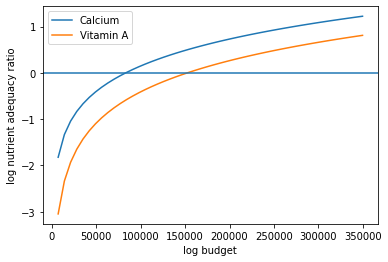

In [26]:
plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('log budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)

Text(0.5, 1.0, 'Nutritional Adequacy of the Bottom 25% Income Household in Uganda')

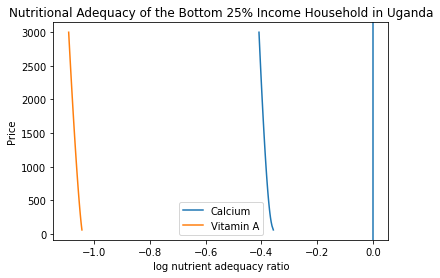

In [27]:
poorer_x = xbar.quantile(0.25, 'j')

plt.plot(pd.concat({p0:np.log(nutrient_adequacy_ratio(poorer_x,my_prices(p0,i=my_i)))[UseNutrients] for p0 in P},axis=1).T,P)
plt.legend(UseNutrients)
plt.ylabel('Price')
plt.xlabel('log nutrient adequacy ratio')
plt.axvline(0)
plt.title('Nutritional Adequacy of the Bottom 25% Income Household in Uganda')

Text(0.5, 1.0, 'Nutritional Adequacy of the Median Income Household in Uganda')

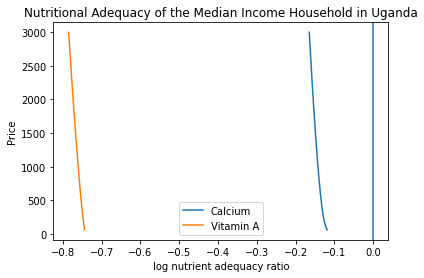

In [28]:
median_x = x0

plt.plot(pd.concat({p0:np.log(nutrient_adequacy_ratio(median_x,my_prices(p0,i=my_i)))[UseNutrients] for p0 in P},axis=1).T,P)
plt.legend(UseNutrients)
plt.ylabel('Price')
plt.xlabel('log nutrient adequacy ratio')
plt.axvline(0)
plt.title('Nutritional Adequacy of the Median Income Household in Uganda')

Text(0.5, 1.0, 'Nutritional Adequacy of the Top 25% Income Household in Uganda')

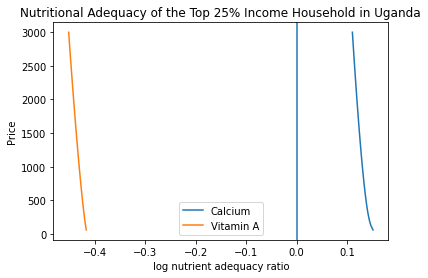

In [29]:
wealthier_x = xbar.quantile(0.75, 'j')

plt.plot(pd.concat({p0:np.log(nutrient_adequacy_ratio(wealthier_x,my_prices(p0,i=my_i)))[UseNutrients] for p0 in P},axis=1).T,P)
plt.legend(UseNutrients)
plt.ylabel('Price')
plt.xlabel('log nutrient adequacy ratio')
plt.axvline(0)
plt.title('Nutritional Adequacy of the Top 25% Income Household in Uganda')

The graphs imply that we need to design a policy that would make foods that are high in calcium and vitamin A less expensive so that lower income households can afford them.

However, we are a little worried about vitamin A because even the top 25% of households in Uganda are not meeting their recommended daily intake of vitamin A.

In [30]:
fct_nutrients = fct.iloc[0:, np.arange(4,11,6)]
fct_nutrients

n,Calcium,Vitamin A
i,,
Beans,270,0
Beef,90,0
Beer,40,0
Bread,1510,0
Bun,1510,0
Cabbages,400,50
Cassava,160,10
Cassava (flour),310,70
Chapati,860,0


Looking at this table, there are many foods that are high in calcium, but it is important to focus on the food that has a high demand elasticity. Looking back at the demand elasticities from earlier, Buns have a high demand elasticity:

In [31]:
print(fct_nutrients.loc['Bun'])
beta.loc['Bun']

n
Calcium      1510
Vitamin A       0
Name: Bun, dtype: int64


0.6146116354448036

There aren't many foods that are high in vitamin A that are in the data. Some foods that are very high in vitamin A, such as Ghee, don't have demand elasticities, so it would be hard to see how to create a policy for those foods.

Eggs seem to have a decent amount of vitamin A while having a somewhat high demand elasticity at the same time:

In [32]:
print(fct_nutrients.loc['Eggs'])
beta.loc['Eggs']

n
Calcium       530
Vitamin A    1400
Name: Eggs, dtype: int64


0.45438412235249837

In [33]:
food_1 = 'Bun'
food_2 = 'Eggs'

### Compensated Policy Experiments



In this part, we will see whether or not it would be worthwhile to subsidize buns and eggs by seeing if calcium and vitamin A intakes would increase to an adequate amount. 

In [34]:
def compensating_variation(U0,p0,p1):
    x0 = r.expenditure(U0,p0)
    x1 = r.expenditure(U0,p1)

    return x1-x0

def revenue(U0,p0,p1,type='Marshallian'):
    """(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    
    dp = p1 - p0 # Change in prices

    c = r.demands(U0,p1,type=type)

    dp,c = dp.align(c,join='inner')

    return dp.T@c


def deadweight_loss(U0,p0,p1):
    """
    Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    cv = compensating_variation(U0,p0,p1)

    return cv - revenue(U0,p0,p1,type='Hicksian') 
    
    
def compensated_nutrient_demand(U,p,z=None):
    c = r.demands(U,p,z=z,type='Hicksian')
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    return N

def compensated_nutrient_adequacy_ratio(U,p):
    return (compensated_nutrient_demand(U,p)/hh_rdi.T).squeeze()

Examine effects of price changes on *compensated* nutrient adequacy (i.e., a price increase is accompanied by additional income to keep utility constant).

Let's first take a look at buns and see if we can increase calcium intake by subsidizing it:

Text(0.5, 0, 'Price of Bun')

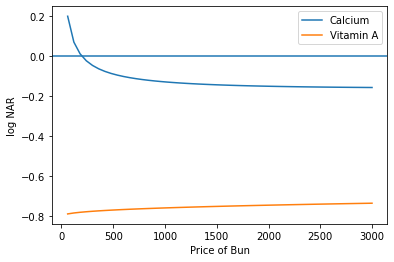

In [35]:
U0 = r.indirect_utility(x0,p)
fig,ax2 = plt.subplots()
ax2.set_ylabel('log NAR')
ax2.plot(P,[np.log(compensated_nutrient_adequacy_ratio(U0,my_prices(p0,i=food_1))[UseNutrients]) for p0 in P])
ax2.legend(UseNutrients)
ax2.axhline(0)
ax2.set_xlabel("Price of %s" % food_1)

It looks like it makes sense to subsidize buns because at a certain price level, there will be more and more people meeting the recommended intake of calcium.

Now, lets look at eggs:

Text(0.5, 0, 'Price of Eggs')

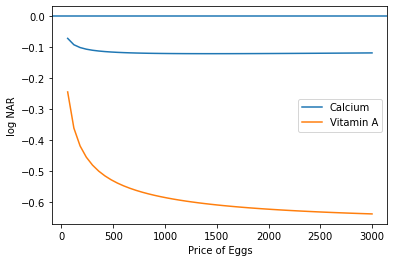

In [36]:
fig,ax2 = plt.subplots()
ax2.set_ylabel('log NAR')
ax2.plot(P,[np.log(compensated_nutrient_adequacy_ratio(U0,my_prices(p0,i=food_2))[UseNutrients]) for p0 in P])
ax2.legend(UseNutrients)
ax2.axhline(0)
ax2.set_xlabel("Price of %s" % food_2)

It looks like subsidizing eggs will increase vitamin A, but not to an adequate amount.

It is hard to say whether or not subsidizing other foods that are rich in vitamin A would increase its intake to an adequate amount because we don't have demand elasticities for a lot of them.

For example, Ghee is rich in vitamin A, but since we don't have a demand elasticity for it, there won't be any changes when we change the price of it:

Text(0.5, 0, 'Price of Ghee')

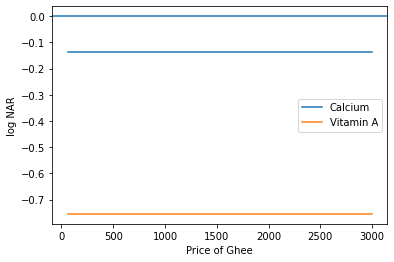

In [37]:
food_3 = 'Ghee'

fig,ax2 = plt.subplots()
ax2.set_ylabel('log NAR')
ax2.plot(P,[np.log(compensated_nutrient_adequacy_ratio(U0,my_prices(p0,i=food_3))[UseNutrients]) for p0 in P])
ax2.legend(UseNutrients)
ax2.axhline(0)
ax2.set_xlabel("Price of %s" % food_3)

In addition, Ghee is relatively expensive compared to other foods rich in vitamin A:

In [38]:
phat.loc['Ghee']

4000.0

Therefore, with what we have to work with, subsidizing buns and eggs would be the best solution.

We will now examine effects of price changes on revenue (if price change due to a tax or subsidy) and compensating variation.

Let's see the graph for buns.

Text(0.5, 1.0, 'Effects of Price Changes on Revenue and Compensating Variation for Buns')

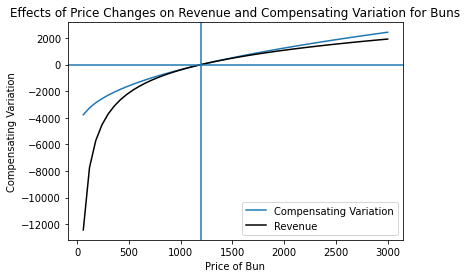

In [39]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,phat,my_prices(p0,i=food_1)) for p0 in P])
ax1.set_xlabel("Price of %s" % food_1)
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,phat,my_prices(p0,i=food_1),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(phat.loc[food_1])
plt.title('Effects of Price Changes on Revenue and Compensating Variation for Buns')

Now let's see the same graph, but for eggs.

Since we don't have data on the price for eggs, we won't have a revenue curve:

Text(0.5, 1.0, 'Effects of Price Changes on Revenue and Compensating Variation for Eggs')

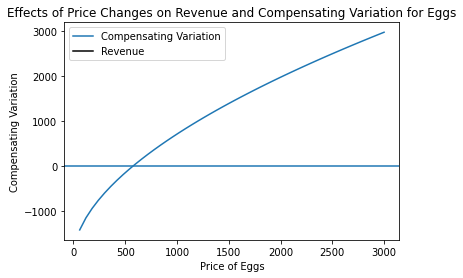

In [40]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,phat,my_prices(p0,i=food_2)) for p0 in P])
ax1.set_xlabel("Price of %s" % food_2)
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,phat,my_prices(p0,i=food_2),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
plt.title('Effects of Price Changes on Revenue and Compensating Variation for Eggs')

Differences between revenue and compensating variation is deadweight-loss.

Let's look at the deadweight-loss for buns and eggs:

Text(0, 0.5, 'Deadweight Loss')

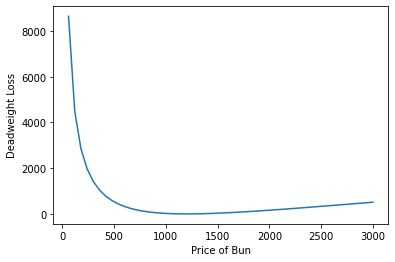

In [41]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,phat,my_prices(p0,i=food_1)) for p0 in P])
ax1.set_xlabel("Price of %s" % food_1)
ax1.set_ylabel("Deadweight Loss")

Again, since we don't have the revenue curve for eggs, we cannot calculate the deadweight loss for it.

Text(0, 0.5, 'Deadweight Loss')

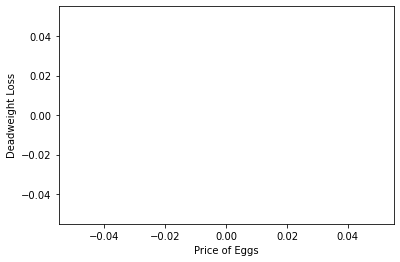

In [42]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,phat,my_prices(p0,i=food_2)) for p0 in P])
ax1.set_xlabel("Price of %s" % food_2)
ax1.set_ylabel("Deadweight Loss")

### Conclusion

Lower income households in Uganda are not meeting the recommended intake for calcium and vitamin A.

A solution would be to subsidize buns, a food rich in calcium, which has a high demand elasticity. Buns cost around 1,200 Ugandan Pounds on average, so looking at the graphs, we should subsidize it to the point where it is around 250 pounds. There would be some deadweight loss, but doing so would allow households to just barely meet the recommended intake of calcium.

However, it is impossible to have households fully meet their recommended intake of vitamin A since many foods rich in vitamin A don't have demand elasticities. Ghee is very rich in vitamin A and it is expensive compared to other foods, so subsidizing it may be an option. For now, subsidizing eggs so that it costs aroud 200 Ugandan Pounds will increase vitamin A intake to an amount closer to the recommendation.